# Import Modules

In [1]:
import os
import json 
import gzip

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

# Get the dataset (Amazon Video Game Reviews)

In [2]:
!curl https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Video_Games_v1_00.tsv.gz -o games.tsv
!gzip -d games.tsv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  453M  100  453M    0     0  22.1M      0  0:00:20  0:00:20 --:--:-- 23.0M
gzip: games.tsv: unknown suffix -- ignored


In [2]:
#!curl https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Video_Games_v1_00.tsv.gz -o games.tsv.gz
#!gzip -d games.tsv.gz

# Load into Pandas DataFrame 

There are a small number of lines in this file that don't parse properly

In [2]:
games = pd.read_csv('games.tsv', delimiter = '\t',error_bad_lines=False)

b'Skipping line 20630: expected 15 fields, saw 22\nSkipping line 28172: expected 15 fields, saw 22\nSkipping line 54791: expected 15 fields, saw 22\n'
b'Skipping line 75419: expected 15 fields, saw 22\nSkipping line 104832: expected 15 fields, saw 22\n'
b'Skipping line 138464: expected 15 fields, saw 22\nSkipping line 194849: expected 15 fields, saw 22\n'
b'Skipping line 201568: expected 15 fields, saw 22\nSkipping line 242567: expected 15 fields, saw 22\n'
b'Skipping line 493585: expected 15 fields, saw 22\nSkipping line 502478: expected 15 fields, saw 22\n'
b'Skipping line 660750: expected 15 fields, saw 22\n'


# Examine Data

In [3]:
games.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12039526,RTIS3L2M1F5SM,B001CXYMFS,737716809,Thrustmaster T-Flight Hotas X Flight Stick,Video Games,5,0,0,N,Y,an amazing joystick. I especially love that yo...,"Used this for Elite Dangerous on my mac, an am...",2015-08-31
1,US,9636577,R1ZV7R40OLHKD,B00M920ND6,569686175,Tonsee 6 buttons Wireless Optical Silent Gamin...,Video Games,5,0,0,N,Y,Definitely a silent mouse... Not a single clic...,"Loved it, I didn't even realise it was a gami...",2015-08-31
2,US,2331478,R3BH071QLH8QMC,B0029CSOD2,98937668,Hidden Mysteries: Titanic Secrets of the Fatef...,Video Games,1,0,1,N,Y,One Star,poor quality work and not as it is advertised.,2015-08-31
3,US,52495923,R127K9NTSXA2YH,B00GOOSV98,23143350,GelTabz Performance Thumb Grips - PlayStation ...,Video Games,3,0,0,N,Y,"good, but could be bettee","nice, but tend to slip away from stick in inte...",2015-08-31
4,US,14533949,R32ZWUXDJPW27Q,B00Y074JOM,821342511,Zero Suit Samus amiibo - Japan Import (Super S...,Video Games,4,0,0,N,Y,Great but flawed.,"Great amiibo, great for collecting. Quality ma...",2015-08-31


In [4]:
games.dtypes

marketplace          object
customer_id           int64
review_id            object
product_id           object
product_parent        int64
product_title        object
product_category     object
star_rating           int64
helpful_votes         int64
total_votes           int64
vine                 object
verified_purchase    object
review_headline      object
review_body          object
review_date          object
dtype: object

The data types all seem to be correct

In [5]:
games.describe()

,customer_id,product_parent,star_rating,helpful_votes,total_votes
count,1.780268e+06,1.780268e+06,1.780268e+06,1.780268e+06,1.780268e+06
mean,2.803021e+07,4.954251e+08,4.059375e+00,2.263971e+00,3.764128e+00
std,1.562851e+07,2.909145e+08,1.355964e+00,1.919211e+01,2.247177e+01
min,1.001800e+04,3.140000e+03,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.429715e+07,2.452708e+08,4.000000e+00,0.000000e+00,0.000000e+00
50%,2.732141e+07,4.920909e+08,5.000000e+00,0.000000e+00,1.000000e+00
75%,4.274834e+07,7.485890e+08,5.000000e+00,1.000000e+00,3.000000e+00
max,5.309656e+07,9.999685e+08,5.000000e+00,1.049800e+04,1.078000e+04


In [26]:
games.star_rating.value_counts()

5    1023102
4     317443
1     191614
3     153443
2      94552
Name: star_rating, dtype: int64

Star ratings tend to be fairly high on average with a mean of 4, most reviews have no helpful_votes but some reviews have a lot of helpful votes

In [6]:
games.isna().sum()

marketplace           0
customer_id           0
review_id             0
product_id            0
product_parent        0
product_title         0
product_category      0
star_rating           0
helpful_votes         0
total_votes           0
vine                  0
verified_purchase     0
review_headline      28
review_body          59
review_date          27
dtype: int64

There are a very small number of NA values, they make up less than .01% of the data so dropping those rows should not have a substantial impact

In [7]:
games.dropna(inplace=True)

In [8]:
games.isna().sum()

marketplace          0
customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        0
product_category     0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
review_headline      0
review_body          0
review_date          0
dtype: int64

In order to get everything the customer wrote for the review, we are combining the 'review_headline' and 'review_body'. There are, however, a large number of reviews where the review headline is just a restatement of the star rating, this is information that is already captured elsewhere so those headlines are being ignored. 

In [24]:
games['review_full'] = np.where(games['review_headline'].str.lower().str.contains('star'), games['review_body'], 
                                games['review_headline'] + ' '+ games['review_body'])

In [25]:
games.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,review_full
0,US,12039526,RTIS3L2M1F5SM,B001CXYMFS,737716809,Thrustmaster T-Flight Hotas X Flight Stick,Video Games,5,0,0,N,Y,an amazing joystick. I especially love that yo...,"Used this for Elite Dangerous on my mac, an am...",2015-08-31,an amazing joystick. I especially love that yo...
1,US,9636577,R1ZV7R40OLHKD,B00M920ND6,569686175,Tonsee 6 buttons Wireless Optical Silent Gamin...,Video Games,5,0,0,N,Y,Definitely a silent mouse... Not a single clic...,"Loved it, I didn't even realise it was a gami...",2015-08-31,Definitely a silent mouse... Not a single clic...
2,US,2331478,R3BH071QLH8QMC,B0029CSOD2,98937668,Hidden Mysteries: Titanic Secrets of the Fatef...,Video Games,1,0,1,N,Y,One Star,poor quality work and not as it is advertised.,2015-08-31,poor quality work and not as it is advertised.
3,US,52495923,R127K9NTSXA2YH,B00GOOSV98,23143350,GelTabz Performance Thumb Grips - PlayStation ...,Video Games,3,0,0,N,Y,"good, but could be bettee","nice, but tend to slip away from stick in inte...",2015-08-31,"good, but could be bettee nice, but tend to sl..."
4,US,14533949,R32ZWUXDJPW27Q,B00Y074JOM,821342511,Zero Suit Samus amiibo - Japan Import (Super S...,Video Games,4,0,0,N,Y,Great but flawed.,"Great amiibo, great for collecting. Quality ma...",2015-08-31,"Great but flawed. Great amiibo, great for coll..."


We are interested in analyzing whether the review was positive or negative, so a new column is being created which classifies a review as positive if it is 4 stars or greater, negative if it is 2 stars or less, and neutral otherwise

In [27]:
games['Sentiment_target'] = np.where(games.star_rating > 3, 'Positive', np.where(games.star_rating < 3, 'Negative', 'Neutral'))

In [30]:
games.Sentiment_target.value_counts()

Positive    1340545
Negative     286166
Neutral      153443
Name: Sentiment_target, dtype: int64

# Preprocessing and visualization

Define a pre-processing function to lemmatize the text and remove stopwords (this will take some time to run)

In [31]:
def preprocess(text):
    words = text.split(' ')
           
    lem = nltk.stem.WordNetLemmatizer()
    words = [lem.lemmatize(word) for word in words]
    
    stopwords = nltk.corpus.stopwords.words('english')
    words = [word for word in words if word not in stopwords]
   
    return ' '.join(words)

In [32]:
games['review_clean'] = games.review_full.apply(preprocess)
games.sample(10)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,review_full,Sentiment_target,review_clean
331393,US,22528082,R2D5R2SP1OWWKO,B0002OOV22,819859658,The Polar Express,Video Games,5,0,0,N,Y,Five Stars,Good experience,2014-12-31,Good experience,Positive,Good experience
932563,US,22706519,R3AS068BK7G4LQ,B008OSDGWO,796115768,Activision Skylanders Giants Single Character ...,Video Games,5,0,0,N,Y,These are great!,I have really enjoyed the skylanders giants ga...,2013-03-16,These are great! I have really enjoyed the sky...,Positive,These great! I really enjoyed skylanders giant...
168935,US,1231443,R1W4EOQB43YEJY,B0053B66KE,413365293,Pokemon Y,Video Games,5,0,0,N,Y,He said it's better than alpha,My boy friend likes it very much. He said it's...,2015-04-03,He said it's better than alpha My boy friend l...,Positive,He said better alpha My boy friend like much. ...
107840,US,31923891,R3TIJSG78DZU8V,B000HKN3ES,233308111,Uno/Skip-Bo/Uno Freefall - Nintendo DS,Video Games,5,0,0,N,Y,Five Stars,awesome,2015-05-27,awesome,Positive,awesome
459096,US,32396187,R345WTX02YLV4J,B0018SRLGE,576680576,Nintendo DS Lite,Video Games,5,0,0,N,Y,Five Stars,"Good, but became old too fast",2014-09-28,"Good, but became old too fast",Positive,"Good, became old fast"
9397,US,4889627,RTHOROORLQ7SE,B001TOQ8WU,556673774,Mario & Luigi Bowser's Inside Story,Video Games,3,0,0,N,Y,Three Stars,very confusing game.,2015-08-23,very confusing game.,Neutral,confusing game.
324455,US,32241003,R7SVKNTKUNX2S,B00000I1BQ,204465540,Crash Bandicoot,Video Games,5,0,0,N,Y,Five Stars,As advertised and on time!,2015-01-03,As advertised and on time!,Positive,As advertised time!
84374,US,39872513,R187UGDON5MMA9,B00HLT0YT0,486771765,Sony Borderlands 2 - Limited Edition - PlaySta...,Video Games,5,0,1,N,Y,You Won't Regret It,Having 2 analog sticks built-in in the device ...,2015-06-18,You Won't Regret It Having 2 analog sticks bui...,Positive,You Won't Regret It Having 2 analog stick buil...
349634,US,18230852,R3FA187QDV5QQN,B000ZKA0J6,39181653,StarCraft II,Video Games,4,0,0,N,Y,Four Stars,It's StarCraft.. what else can you say?,2014-12-24,It's StarCraft.. what else can you say?,Positive,It's StarCraft.. else say?
155299,US,7823421,R3TWW5SMDBZALP,B003UI5GLC,106432801,Gen Classic N64 Controller Grey,Video Games,5,0,0,N,Y,Woot love this.,Great addition to my controllers for the n64,2015-04-14,Woot love this. Great addition to my controlle...,Positive,Woot love this. Great addition controller n64


In [33]:
from wordcloud import WordCloud

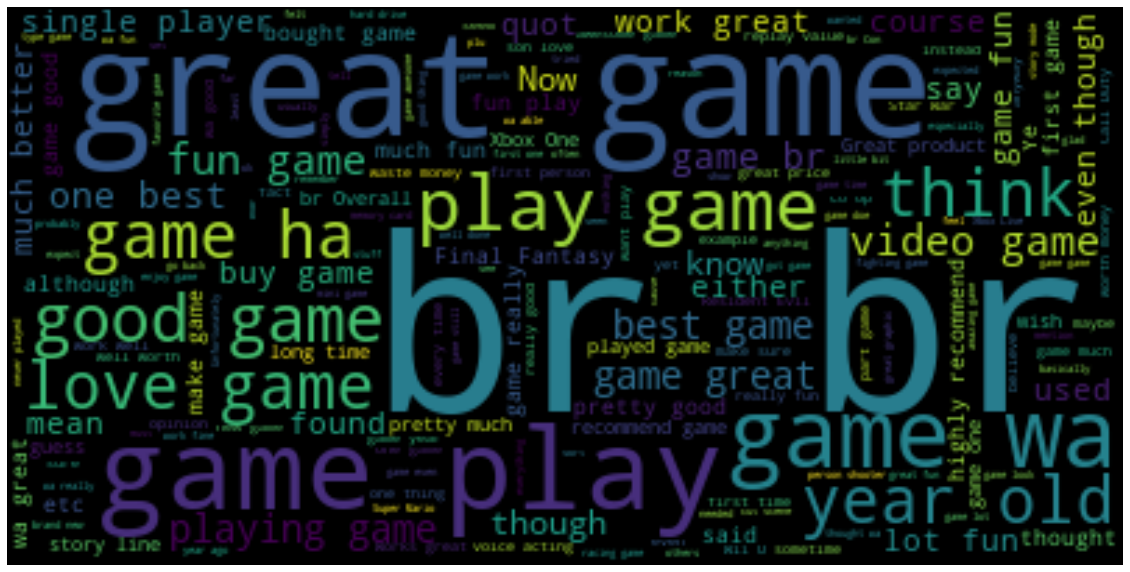

In [34]:
full_text = ' '.join(games.review_clean)
wordcloud = WordCloud().generate(full_text)

plt.rcParams["figure.figsize"] = (20,15)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

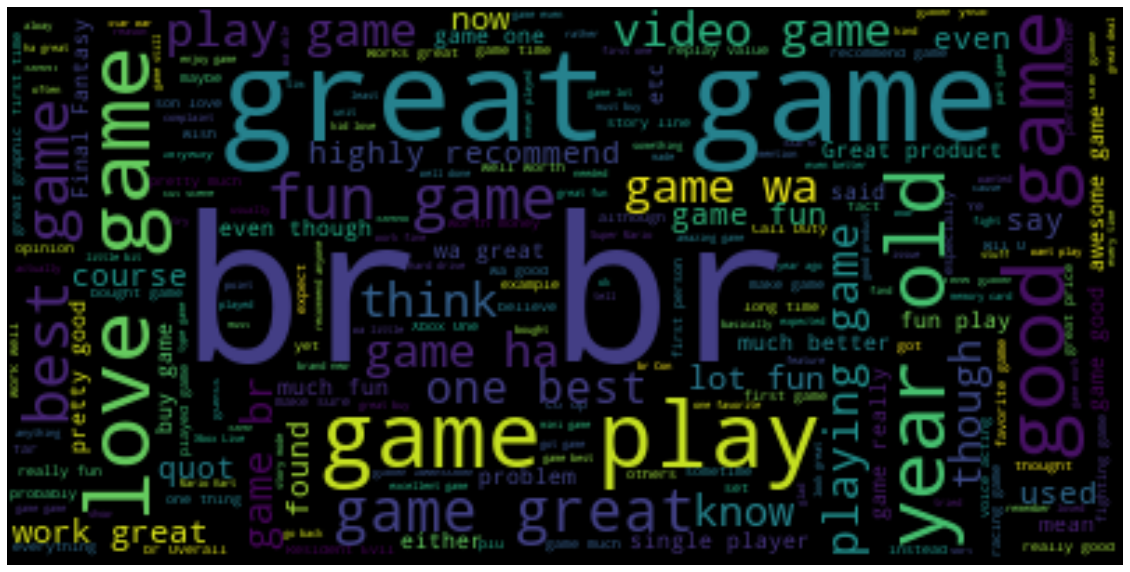

In [36]:
full_text = ' '.join(games.review_clean[games.Sentiment_target=='Positive'])
wordcloud = WordCloud().generate(full_text)

plt.rcParams["figure.figsize"] = (20,15)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

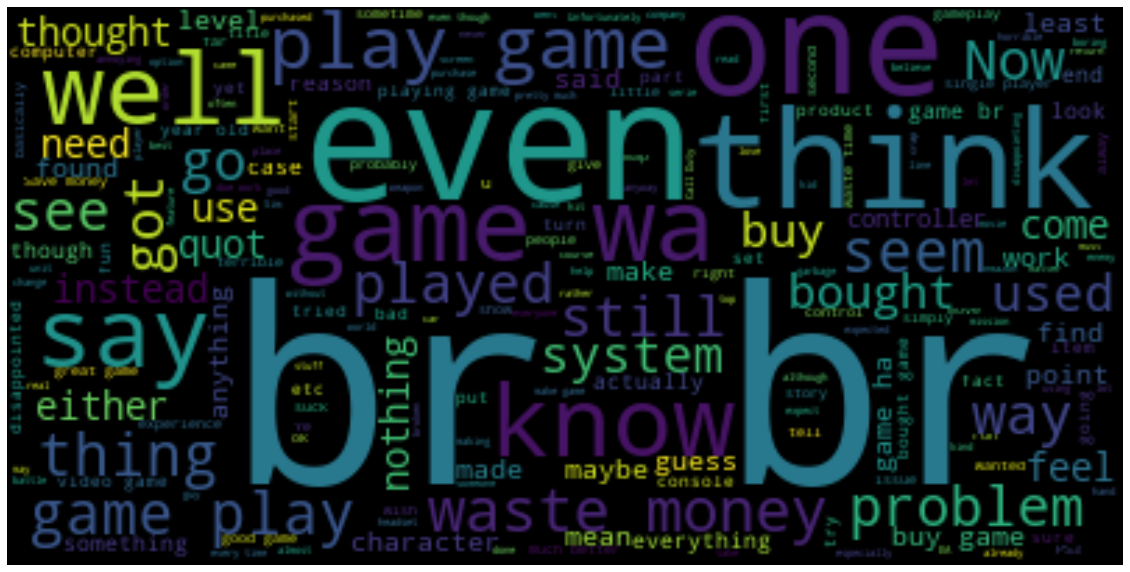

In [37]:
full_text = ' '.join(games.review_clean[games.Sentiment_target=='Negative'])
wordcloud = WordCloud().generate(full_text)

plt.rcParams["figure.figsize"] = (20,15)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Set up NLP [RAJA BROKEN]

In [16]:
# import nltk
# nltk.download('stopwords') 
# nltk.download('wordnet')

# from nltk.stem import WordNetLemmatizer
# from nltk.tokenize import RegexpTokenizer
# from nltk.corpus import stopwords
# from sklearn.feature_extraction.text import TfidfVectorizer

# def preprocess_text(text):
#     # Tokenise words while ignoring punctuation
#     tokeniser = RegexpTokenizer(r'\w+')
#     tokens = tokeniser.tokenize(text)

#     # Lowercase and lemmatise 
#     lemmatiser = WordNetLemmatizer()
#     lemmas = [lemmatiser.lemmatize(token.lower(), pos='v') for token in tokens]

#     # Remove stopwords
#     keywords= [lemma for lemma in lemmas if lemma not in stopwords.words('english')]
#     return keywords


# X_train = video_game_data[['reviewText']]

# vectoriser = TfidfVectorizer(analyzer=preprocess_text)
# # Fit to the data and transform to feature matrix
# X_train = vectoriser.fit_transform(X_train['reviewText'])
# # Convert sparse matrix to dataframe
# X_train = pd.DataFrame.sparse.from_spmatrix(X_train)
# # Save mapping on which index refers to which words
# col_map = {v:k for k, v in vectoriser.vocabulary_.items()}
# # Rename each column using the mapping
# for col in X_train.columns:
#     X_train.rename(columns={col: col_map[col]}, inplace=True)
# X_train



## Tensorflow NLP

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix

from keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import model_from_json
import re
import warnings 
warnings.filterwarnings('ignore')
from subprocess import check_output


In [7]:
!curl https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Video_Games_v1_00.tsv.gz -o games.tsv.gz
!gzip -d games.tsv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  453M  100  453M    0     0  19.6M      0  0:00:23  0:00:23 --:--:-- 20.3M


In [8]:
games = pd.read_csv('games.tsv', sep='\t', error_bad_lines=False)

b'Skipping line 20630: expected 15 fields, saw 22\nSkipping line 28172: expected 15 fields, saw 22\nSkipping line 54791: expected 15 fields, saw 22\n'
b'Skipping line 75419: expected 15 fields, saw 22\nSkipping line 104832: expected 15 fields, saw 22\n'
b'Skipping line 138464: expected 15 fields, saw 22\nSkipping line 194849: expected 15 fields, saw 22\n'
b'Skipping line 201568: expected 15 fields, saw 22\nSkipping line 242567: expected 15 fields, saw 22\n'
b'Skipping line 493585: expected 15 fields, saw 22\nSkipping line 502478: expected 15 fields, saw 22\n'
b'Skipping line 660750: expected 15 fields, saw 22\n'


In [9]:
games.columns

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date'],
      dtype='object')

In [10]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1780268 entries, 0 to 1780267
Data columns (total 15 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   marketplace        object
 1   customer_id        int64 
 2   review_id          object
 3   product_id         object
 4   product_parent     int64 
 5   product_title      object
 6   product_category   object
 7   star_rating        int64 
 8   helpful_votes      int64 
 9   total_votes        int64 
 10  vine               object
 11  verified_purchase  object
 12  review_headline    object
 13  review_body        object
 14  review_date        object
dtypes: int64(5), object(10)
memory usage: 203.7+ MB


In [11]:
games.describe()

,customer_id,product_parent,star_rating,helpful_votes,total_votes
count,1.780268e+06,1.780268e+06,1.780268e+06,1.780268e+06,1.780268e+06
mean,2.803021e+07,4.954251e+08,4.059375e+00,2.263971e+00,3.764128e+00
std,1.562851e+07,2.909145e+08,1.355964e+00,1.919211e+01,2.247177e+01
min,1.001800e+04,3.140000e+03,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.429715e+07,2.452708e+08,4.000000e+00,0.000000e+00,0.000000e+00
50%,2.732141e+07,4.920909e+08,5.000000e+00,0.000000e+00,1.000000e+00
75%,4.274834e+07,7.485890e+08,5.000000e+00,1.000000e+00,3.000000e+00
max,5.309656e+07,9.999685e+08,5.000000e+00,1.049800e+04,1.078000e+04


In [12]:
games.duplicated().sum()

0

In [13]:
games.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12039526,RTIS3L2M1F5SM,B001CXYMFS,737716809,Thrustmaster T-Flight Hotas X Flight Stick,Video Games,5,0,0,N,Y,an amazing joystick. I especially love that yo...,"Used this for Elite Dangerous on my mac, an am...",2015-08-31
1,US,9636577,R1ZV7R40OLHKD,B00M920ND6,569686175,Tonsee 6 buttons Wireless Optical Silent Gamin...,Video Games,5,0,0,N,Y,Definitely a silent mouse... Not a single clic...,"Loved it, I didn't even realise it was a gami...",2015-08-31
2,US,2331478,R3BH071QLH8QMC,B0029CSOD2,98937668,Hidden Mysteries: Titanic Secrets of the Fatef...,Video Games,1,0,1,N,Y,One Star,poor quality work and not as it is advertised.,2015-08-31
3,US,52495923,R127K9NTSXA2YH,B00GOOSV98,23143350,GelTabz Performance Thumb Grips - PlayStation ...,Video Games,3,0,0,N,Y,"good, but could be bettee","nice, but tend to slip away from stick in inte...",2015-08-31
4,US,14533949,R32ZWUXDJPW27Q,B00Y074JOM,821342511,Zero Suit Samus amiibo - Japan Import (Super S...,Video Games,4,0,0,N,Y,Great but flawed.,"Great amiibo, great for collecting. Quality ma...",2015-08-31


In [14]:
len(games)

1780268

In [15]:
games.iloc[0:20].review_headline

0     an amazing joystick. I especially love that yo...
1     Definitely a silent mouse... Not a single clic...
2                                              One Star
3                             good, but could be bettee
4                                     Great but flawed.
5                                              One Star
6                                                A Must
7                                            Five Stars
8                                            Five Stars
9                                            Four Stars
10                                           Five Stars
11                                  Game will get stuck
12    We have tried it with kids ages 4-7 and none o...
13                                           Four Stars
14    Now i have to buy a better one. Sorry guys but...
15                                           Five Stars
16                                           Five Stars
17                                           Fiv

In [16]:
games.iloc[0:5].review_body

0    Used this for Elite Dangerous on my mac, an am...
1    Loved it,  I didn't even realise it was a gami...
2       poor quality work and not as it is advertised.
3    nice, but tend to slip away from stick in inte...
4    Great amiibo, great for collecting. Quality ma...
Name: review_body, dtype: object

In [17]:
games = games[['review_body','star_rating']]

In [18]:
games

,review_body,star_rating
0,"Used this for Elite Dangerous on my mac, an am...",5
1,"Loved it, I didn't even realise it was a gami...",5
2,poor quality work and not as it is advertised.,1
3,"nice, but tend to slip away from stick in inte...",3
4,"Great amiibo, great for collecting. Quality ma...",4
...,...,...
1780263,I don't think it is necessary for me to wax po...,5
1780264,If I could rate higher than a ten I would. Thi...,5
1780265,Fewer than 1 in 3 modern Windows computers are...,1
1780266,Unfortunately Riven is available only to those...,1


In [19]:
row_select_1 = games['star_rating'] < 3
row_select_2 = games['star_rating'] == 3
games['sentiment'] = pd.Series(['Positive']*len(games.index))
games.loc[row_select_1,'sentiment'] = 'Negative'
games.loc[row_select_2,'sentiment'] = 'Neutral'

In [20]:
games = games[['review_body','sentiment']]
games.columns = ['text', 'sentiment']

In [21]:
games

,text,sentiment
0,"Used this for Elite Dangerous on my mac, an am...",Positive
1,"Loved it, I didn't even realise it was a gami...",Positive
2,poor quality work and not as it is advertised.,Negative
3,"nice, but tend to slip away from stick in inte...",Neutral
4,"Great amiibo, great for collecting. Quality ma...",Positive
...,...,...
1780263,I don't think it is necessary for me to wax po...,Positive
1780264,If I could rate higher than a ten I would. Thi...,Positive
1780265,Fewer than 1 in 3 modern Windows computers are...,Negative
1780266,Unfortunately Riven is available only to those...,Negative


In [22]:
# Embedding
max_features = 20000
maxlen = 100
embedding_size = 128

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

# Training
batch_size = 30
epochs = 2

In [23]:
games = games[games.sentiment != "Neutral"]
games['text'] = games['text'].apply(lambda x: str(x).lower())
games['text'] = games['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(games[ games['sentiment'] == 'Positive'].size)
print(games[ games['sentiment'] == 'Negative'].size)

for idx,row in games.iterrows():
    row[0] = row[0].replace('rt',' ')
    
tokenizer = Tokenizer(nb_words = max_features, split=' ')
tokenizer.fit_on_texts(games['text'].values)
X = tokenizer.texts_to_sequences(games['text'].values)
X = pad_sequences(X, maxlen = maxlen)

2681254
572380


In [24]:
Y = pd.get_dummies(games['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1301453, 100) (1301453, 2)
(325364, 100) (325364, 2)


In [25]:
print('Build model...')

model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Dropout(0.25))
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(lstm_output_size))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Build model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 128)          2560000   
_________________________________________________________________
dropout (Dropout)            (None, 100, 128)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 64)            41024     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 24, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 70)                37800     
_________________________________________________________________
dense (Dense)                (None, 2)                 142       
Total params: 2,638,966
Trainable params: 2,638,966
Non-trainable params: 0
_______________________________

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

NameError: name 'tf' is not defined

In [ ]:
print('Train...')
model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,shuffle=True, validation_data=(X_test, Y_test))

Train...
Epoch 1/2
43382/43382 [==============================] - 686s 16ms/step - loss: 0.1203 - accuracy: 0.9546 - val_loss: 0.1274 - val_accuracy: 0.9519


In [ ]:
yhat = model.predict(X_test, verbose = 2, batch_size = batch_size)
from sklearn import metrics
print(metrics.classification_report(Y_test[:,1], np.round(yhat[:,1]) ,target_names = ["negative", "positive"]))

10846/10846 - 25s
              precision    recall  f1-score   support

    negative       0.87      0.86      0.86     57004
    positive       0.97      0.97      0.97    268360

    accuracy                           0.95    325364
   macro avg       0.92      0.91      0.92    325364
weighted avg       0.95      0.95      0.95    325364



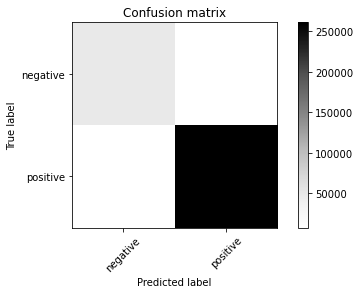

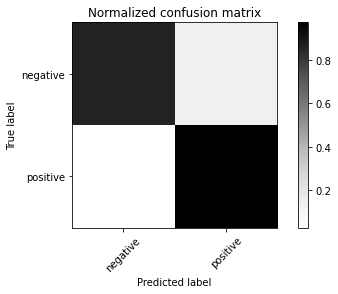

In [ ]:
score = ['negative', 'positive']

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Greys):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(set(score)))
    plt.xticks(tick_marks, score, rotation=45)
    plt.yticks(tick_marks, score)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cm = confusion_matrix(Y_test[:,1], np.round(yhat[:,1]))
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm)    

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model_conv_lstm.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_conv_lstm.h5")

.

### Citation For data:
    
Justifying recommendations using distantly-labeled reviews and fined-grained aspects
Jianmo Ni, Jiacheng Li, Julian McAuley
Empirical Methods in Natural Language Processing (EMNLP), 2019